# Imports, load data

In [1]:
import time
import warnings
from collections import namedtuple
import os
import pickle as pkl
import ast

from IPython.display import display, clear_output
from ipywidgets import IntProgress

import numpy as np
import matplotlib.pyplot as plt

from src.rbm import RBM
from src.utils import load_model, progress_bar

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
H_AFR = np.loadtxt('data/H_AFR.txt')
H_AMR = np.loadtxt('data/H_AMR.txt')
H_EAS = np.loadtxt('data/H_EAS.txt')
H_EUR = np.loadtxt('data/H_EUR.txt')

# Train

In [6]:
p2H = {'AFR': H_AFR, 'AMR': H_AMR, 'EAS': H_EAS, 'EUR': H_EUR}

params = [
    {'n_components': 100, 'n_iter': 6, 'learning_rate': 0.03, 'population': p, 
     'verbose': True, 'note': 'td50'} for p in ['AFR', 'AMR', 'EAS', 'EUR']
]

rbm_dict = dict()
for p_dict in params:
    rbm = RBM(**p_dict)
    H = p2H[p_dict['population']][:-50]
    rbm.fit(p2H[p_dict['population']])
    rbm.save()
    
    rbm_dict[p_dict['population']] = rbm

[RBM] Iteration 1, pseudo-likelihood = -5027.97, time = 1.08s
[RBM] Iteration 2, pseudo-likelihood = -4038.59, time = 1.08s
[RBM] Iteration 3, pseudo-likelihood = -4740.47, time = 1.06s
[RBM] Iteration 4, pseudo-likelihood = -4234.92, time = 1.04s
[RBM] Iteration 5, pseudo-likelihood = -4024.94, time = 1.05s
[RBM] Iteration 6, pseudo-likelihood = -3759.40, time = 1.13s
Saved RBM(batch_size=10, learning_rate=0.03, n_components=100, n_iter=6,
  note='td50', population='AFR', random_state=None, verbose=True)
[RBM] Iteration 1, pseudo-likelihood = -5069.79, time = 0.73s
[RBM] Iteration 2, pseudo-likelihood = -5013.42, time = 0.76s
[RBM] Iteration 3, pseudo-likelihood = -4778.61, time = 0.92s
[RBM] Iteration 4, pseudo-likelihood = -4480.12, time = 0.81s
[RBM] Iteration 5, pseudo-likelihood = -3748.45, time = 0.75s
[RBM] Iteration 6, pseudo-likelihood = -4302.80, time = 0.75s
Saved RBM(batch_size=10, learning_rate=0.03, n_components=100, n_iter=6,
  note='td50', population='AMR', random_stat

# Impute

In [8]:
m = H_AFR.shape[1]

H_valid = np.zeros((0, m))
for H in [H_AFR, H_AMR, H_EUR, H_EAS]:
    H_valid = np.vstack([H_valid, H[-50:, :]])

results = dict()
for k in ['AFR', 'EUR', 'EAS', 'AMR']:
    results[k] = np.zeros((H_valid.shape[0], 0))
    
results['model_info'] = []
results['H_valid_info'] = 'AFR=[0,50]; EUR=[50,100]; EAS=[100,150]; AMR=[150, 200]'

prog = IntProgress(value=0, max=m)
display(prog)

for pop, rbm in rbm_dict.items():
    
    results['model_info'].append(str(rbm))
    print(str(rbm))
    
    prog.value = 0
    
    for col in range(m):
        out = rbm.impute(H_valid, position=col).reshape(-1, 1)
        results[rbm.population] = np.hstack([results[rbm.population], out])
        prog.value += 1
        
    fpath = 'data/imputations_t50_TMP.p'
    f = open(fpath, 'wb')
    pkl.dump(results, f)
    f.close()
        
prog.close()

f = open('data/imputations_t50.p', 'wb')
pkl.dump(results, f)
f.close()

IntProgress(value=0, max=7596)

RBM(batch_size=10, learning_rate=0.03, n_components=100, n_iter=6,
  note='td50', population='EUR', random_state=None, verbose=True)
RBM(batch_size=10, learning_rate=0.03, n_components=100, n_iter=6,
  note='td50', population='AMR', random_state=None, verbose=True)
RBM(batch_size=10, learning_rate=0.03, n_components=100, n_iter=6,
  note='td50', population='EAS', random_state=None, verbose=True)
RBM(batch_size=10, learning_rate=0.03, n_components=100, n_iter=6,
  note='td50', population='AFR', random_state=None, verbose=True)


# Visualize

[1] {'lr': '0.05', 'ni': '3', 'nc': '100', 'bs': '10', 'pop': 'EUR.p', 'note': 'td50'}
[2] {'lr': '0.05', 'ni': '3', 'nc': '100', 'bs': '10', 'pop': 'EAS.p', 'note': 'td50'}
[3] {'lr': '0.05', 'ni': '3', 'nc': '100', 'bs': '10', 'pop': 'AFR.p', 'note': 'td50'}
[7] {'lr': '0.05', 'ni': '3', 'nc': '100', 'bs': '10', 'pop': 'AMR.p', 'note': 'td50'}
Which file number?
7


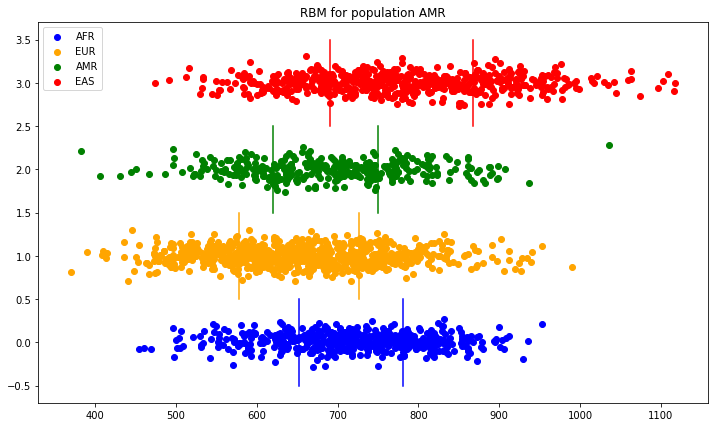

AFR: 454.903579
EUR: 370.135028
EAS: 473.735209
AMR: 382.147804


In [28]:
rbm = load_model(min_units=60)
v_AFR = H_AFR[100]
v_EUR = H_EUR[100]
v_EAS = H_EAS[100]
v_AMR = H_AMR[100]

Fv_AFR = rbm.free_energy(H_AFR)
Fv_EUR = rbm.free_energy(H_EUR)
Fv_AMR = rbm.free_energy(H_AMR)
Fv_EAS = rbm.free_energy(H_EAS)

f, ax = plt.subplots(figsize=(12, 7))

def noise(arr):
    arr = np.array(arr)
    return arr + np.random.randn(*arr.shape) * 0.1

# ============================================
ax.scatter(Fv_AFR, noise([0]*len(Fv_AFR)), label='AFR', c='blue')
q25 = sorted(Fv_AFR)[int(len(Fv_AFR) / 4)]
ax.plot([q25, q25], [-.5, .5], color='blue', zorder=5)
q75 = sorted(Fv_AFR)[3 * int(len(Fv_AFR) / 4)]
ax.plot([q75, q75], [-.5, .5], color='blue', zorder=5)

ax.scatter(Fv_EUR, noise([1]*len(Fv_EUR)), label='EUR', c='orange')
q25 = sorted(Fv_EUR)[int(len(Fv_EUR) / 4)]
ax.plot([q25, q25], [.5, 1.5], color='orange', zorder=5)
q75 = sorted(Fv_EUR)[3 * int(len(Fv_EUR) / 4)]
ax.plot([q75, q75], [.5, 1.5], color='orange', zorder=5)

ax.scatter(Fv_AMR, noise([2]*len(Fv_AMR)), label='AMR', c='green')
q25 = sorted(Fv_AMR)[int(len(Fv_AMR) / 4)]
ax.plot([q25, q25], [1.5, 2.5], color='green', zorder=5)
q75 = sorted(Fv_AMR)[3 * int(len(Fv_AMR) / 4)]
ax.plot([q75, q75], [1.5, 2.5], color='green', zorder=5)

ax.scatter(Fv_EAS, noise([3]*len(Fv_EAS)), label='EAS', c='red')
q25 = sorted(Fv_EAS)[int(len(Fv_EAS) / 4)]
ax.plot([q25, q25], [2.5, 3.5], color='red', zorder=5)
q75 = sorted(Fv_EAS)[3 * int(len(Fv_EAS) / 4)]
ax.plot([q75, q75], [2.5, 3.5], color='red', zorder=5)
# ============================================

ax.set_title('RBM for population %s' % rbm.population)
plt.legend()
plt.show()


print('AFR: %f' % Fv_AFR.min())
print('EUR: %f' % Fv_EUR.min())
print('EAS: %f' % Fv_EAS.min())
print('AMR: %f' % Fv_AMR.min())

In [20]:
mx = 6151
mn = 4060

bins = np.linspace(mn, mx, 50)

hist_AFR, _ = np.histogram(Fv_AFR, bins=bins)
hist_EUR, _ = np.histogram(Fv_EUR, bins=bins)
hist_AMR, _ = np.histogram(Fv_AMR, bins=bins)
hist_EAS, _ = np.histogram(Fv_EAS, bins=bins)

# print(hist_AFR.shape)

# h_ALL = hist_AFR + hist_EUR + hist_AMR + hist_EAS

for i in range(len(h_ALL)):
    s = hist_AFR[i] + hist_AMR[i] + hist_EAS[i] + hist_EUR[i]
    hist_AFR[i] /= s
    hist_AMR[i] /= s
    hist_EAS[i] /= s
    hist_EUR[i] /= s

f, ax = plt.subplots(figsize=(12, 7))

for i in range(len(bins) - 1):
    bs, be = bins[i], bins[i+1]
    
    bottom = 0
    p_AFR = hist_AFR[i] / h_ALL[i]
    lg = 'AFR' if i == 0 else None
    ax.fill_between(
        [bs, be], [bottom, bottom], [p_AFR, p_AFR], color='blue', label=lg
    )
    
    bottom += p_AFR
    p_AMR = hist_AMR[i] / h_ALL[i]
    lg = 'AMR' if i == 0 else None
    ax.fill_between(
        [bs, be], [bottom, bottom], [bottom+p_AMR, bottom+p_AMR], 
        color='green', label=lg
    )
    
    bottom += p_AMR
    p_EUR = hist_EUR[i] / h_ALL[i]
    lg = 'EUR' if i == 0 else None
    ax.fill_between(
        [bs, be], [bottom, bottom], [bottom+p_EUR, bottom+p_EUR], 
        color='orange', label=lg
    )
    
    bottom += p_EUR
    p_EAS = hist_EUR[i] / h_ALL[i]
    lg = 'EAS' if i == 0 else None
    ax.fill_between(
        [bs, be], [bottom, bottom], [bottom+p_EAS, bottom+p_EAS], 
        color='red', label=lg
    )
    
#     print(i, p_AFR, p_AMR, p_EUR, p_EAS)
    
plt.legend()
plt.show()

/home/cole/.virtualenvs/RL/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


ValueError: cannot convert float NaN to integer